In [132]:
# Standard imports
import warnings
# Standard from-imports
from pathlib import Path
# Third-party imports
import numpy as np
import pandas as pd
# Third-party from-imports
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin

In [330]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src' directory as one where we can import modules
from os import path
import sys
src_dir = path.join("..", 'src')
sys.path.append(src_dir)

# import my method from the source code
%aimport features.build_features
%aimport models.fit_predict
%aimport visualization.visualize
%aimport evaluation.kappa

from evaluation.kappa import kappa

## Transformer definitions

In [316]:
class NoObservationsDropper(BaseEstimator, TransformerMixin):
    def __init__(self, n_obs=7, cols=None):
        cols = cols or []
        cols = cols[:n_obs]
        self.cols = cols
        print(self.cols)
        self.indices = None
    
    def fit(self, X, y=None):
        self.indices = X[self.cols].notna().any(axis='columns')
        return self
    
    def transform(self, X, y, groups):
        ids = self.indices
        X, y, groups = X[ids], y[ids], groups[ids]
        return X, y, groups

In [91]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    """Delete rows with extreme target values."""
    def __init__(self, bottom_pct=5, top_pct=95):
        self.bottom_frac = bottom_pct
        self.top_frac = top_pct
        self.indices = None
    
    def fit(self, y):
        assert y is not None
        bottom_val, top_val = np.percentile(y, [self.bottom_frac, self.top_frac])
        self.indices = (y > bottom_val) & (y < top_val)
        print(f"Retained {(sum(self.indices) / len(y) * 100):.1f}% after removing outliers.")
        return self
    
    def transform(self, X, y, groups):
        ids = self.indices
        X, y, groups = X[ids], y[ids], groups[ids]
        return X, y, groups

In [92]:
from scipy.stats.mstats import winsorize

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, limits=0.05):
        assert 0 <= limits <= 0.5
        self.limits = limits
    
    def fit(self, y):
        return self
    
    def transform(self, y):
        return winsorize(y, limits=self.limits).data

In [114]:
class NaColFiller(BaseEstimator, TransformerMixin):
    def __init__(self, method, cols=None):
        self.cols = cols or []
        self.method = method
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        data = data.copy(deep=True)
        data[self.cols] = data[self.cols].fillna(method=self.method, axis='columns')
        return data

In [126]:
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols or []
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.drop(self.cols, axis=1)

In [299]:
class ValueScale(BaseEstimator, TransformerMixin):
    def __init__(self, value=100):
        self.value = value
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data / self.value

In [124]:
class Cloner(BaseEstimator, TransformerMixin):        
    def fit(self, x, y=None):
        return self
    
    def transform(self, data):
        return data.copy()

## PyTorch Regressor

### Trainer

In [427]:
import sys
import time
import torch as th


from random import shuffle
from tqdm import tqdm_notebook, tnrange


class PyTorchTrainer(object):
    
    def __init__(self, trainable_agent, loss_fn, epochs=1, evaluate=None, optimizer=None):
        self._model = trainable_agent
        self._loss_fn = loss_fn
        if optimizer is None:
            # create an optimizer with the default settings
            # model.parameters() is a list of all the trainable parameters in the model
            optimizer = torch.optim.Adam(self._model.parameters())
        self._optimizer = optimizer
        self._epochs = epochs
        self._evaluate = evaluate
        
    def train(self, dataset):
        iteration = 0
        dataset = list(dataset)
        running_loss = 0
        start = time.time()
        for epoch in tnrange(self._epochs, desc='Epoch', leave=True):
            shuffle(dataset)
            for (minibatch, target) in dataset:
                # compute the loss from the model (trainable decision agent)
                y_pred = self._model(minibatch)
                loss = self._loss_fn(y_pred, target.float())
                # compute the gradients on the computation graph
                loss.backward()  
                # make the optimizer take a step using the computed gradients
                self._optimizer.step()
                # zero out the gradients for the next step
                self._optimizer.zero_grad()
                running_loss = running_loss * .99 + float(loss)
                iteration += 1
                
                
                if iteration % 50 == 0:
                    # print progress
                    done = iteration / (len(dataset) * self._epochs)
                    now = time.time()
                    total_time = (now - start) / done
                    # print(f'\ttrained for {iteration} iterations, loss {running_loss/100} '
                    #                  f'{int(done*100)}% time: {int((now - start) / 60)}/{int(total_time / 60)} (min)  ') 
            if self._evaluate:
                # print('\n')
                self._evaluate(self._model)

            y_labels = target.detach().numpy()
            y_pred_results = y_pred.detach().numpy()
            error = mean_absolute_error(y_labels, y_pred_results)
            # self._history["mse_loss"].append(loss.item())
            # self._history["loss"].append(error)
            # print(f"Results for epoch {epoch + 1}: \
            #     loss {error}, mse_loss: {loss.item()}")



### Actual regressor



In [423]:
import inspect  # Efficient way to initialize the object.

import torch
import torch.utils.data as  data_utils

from math import ceil
from sklearn.metrics import mean_absolute_error

class PyTorchRegressor(BaseEstimator, RegressorMixin):
    """
    A PyTorch Regressor.
    
    Implementation adapted from:
    kaggle.com/graymant/pytorch-regression-with-sklearn-pipelines
    """
    
    def __init__(self, output_dim=1, input_dim=100, 
                 hidden_layer_dims=[100, 100],
                 epochs=1, learning_rate=0.001,
                 batch_size=128, shuffle=False,
                 callbacks=[], verbose=1):
        self._history = None
        self._model = None
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        
        for arg, val in values.items():
            setattr(self, arg, val)
            
    def _build_model(self):
        self._layer_dims = ([self.input_dim] + self.hidden_layer_dims +
            [self.output_dim])
        self._model = torch.nn.Sequential()
        
        # Loop through the layer dimensions and create an input layer,
        # then create each hidden layer with relu activation.
        for idx, dim in enumerate(self._layer_dims):
            if (idx < len(self._layer_dims) - 1):
                module = torch.nn.Linear(dim, self._layer_dims[idx + 1])
                torch.nn.init.xavier_uniform_(module.weight)
                self._model.add_module("linear" + str(idx), module)

            if (idx < len(self._layer_dims) - 2):
                self._model.add_module("relu" + str(idx), torch.nn.ReLU())
                
    def _train_model(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values
        torch_x = torch.from_numpy(X).float()
        torch_y = torch.from_numpy(y).float().view(-1, 1)

        train = data_utils.TensorDataset(torch_x, torch_y)
        train_loader = data_utils.DataLoader(train, 
                                             batch_size=self.batch_size,
                                             shuffle=self.shuffle)

        loss_fn = torch.nn.MSELoss(size_average=False)
        
        optimizer = torch.optim.Adam(
            self._model.parameters(), lr=self.learning_rate)
        
        trainer = PyTorchTrainer(self._model, log_cosh_loss, 
                                 epochs=self.epochs,
                                 optimizer=optimizer,
                                )
        trainer.train(train_loader)
        
#         self._history = {
#             "loss": [],
#             "val_loss": [],
#             "mse_loss": [],
#         }
        
        
#         finish = False
#         for epoch in range(self.epochs):
#             if finish:
#                 break
            
#             loss = None
#             idx = 0
#             for idx, (minibatch, target) in enumerate(train_loader):
#                 y_pred = self._model(minibatch)
                
#                 loss = loss_fn(y_pred, target.float())
                
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
            
#             y_labels = target.detach().numpy()
#             y_pred_results = y_pred.detach().numpy()
            
#             error = mean_absolute_error(y_labels, y_pred_results)
            
#             self._history["mse_loss"].append(loss.item())
#             self._history["loss"].append(error)
            
#             if self.verbose > 0:
#                 print(f"Results for epoch {epoch + 1}: \
#                     loss {error}, mse_loss: {loss.item()}")
            
#             for callback in self.callbacks:
#                 callback.call(self._model, self._history)
#                 if callback.finish:
#                     finish = True
#                     break
                    
    def fit(self, X, y):
        assert (type(self.input_dim) ==
                int), "input_dim parameter must be defined"
        assert (type(self.output_dim) == 
                int), "output_dim must be defined"

        self._build_model()
        self._train_model(X, y)

        return self

    def predict(self, X, y=None):
#         if self._history == None:
#             raise RuntimeError("Regressor has not been fit.")

        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(y, pd.Series):
            y = y.values

        results = []
        split_size = ceil(len(X) / self.batch_size)
        
        for batch in np.array_split(X, split_size):
            x_pred = torch.from_numpy(batch).float()
            y_pred = self._model(x_pred)
            y_pred_numpy = y_pred.detach().numpy()
            results = np.append(results, y_pred_numpy)
        
        return results
    
    def score(self, X, y, sample_weight=None):
        y_pred = self.predict(X, y)
        return -1 * mean_absolute_error(y, y_pred)

### Loss function

In [424]:
def log_cosh_loss(y_true, y_pred):
    """Logarithm of the hyperbolic cosine of the prediction error.
    `log(cosh(x))` is approximately equal to `(x ** 2) / 2` for small `x` and
    to `abs(x) - log(2)` for large `x`. This means that 'logcosh' works mostly
    like the mean squared error, but will not be so strongly affected by the
    occasional wildly incorrect prediction.
    
    Arguments:
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.
    Returns:
        Tensor with one scalar loss entry per sample.
    """
    
    # Legit ripped this straight out of Keras. fchollet, bless.
    def _logcosh(x):
        # Numerically stable form.
        return x + torch.nn.functional.softplus(-2. * x) - np.log(2.)
    
    return torch.mean(_logcosh(y_true - y_pred))

In [425]:
# X = np.random.rand(100, 30)
# y = np.random.rand(100, 1)

PyTorchRegressor(input_dim=X.shape[1], epochs=40).fit(X, y).score(X, y)

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

-2.1178694138416798

## Data transformation pipeline

In [459]:
folder = Path("..") / "data" / "processed"

X = pd.read_csv(folder / "X.csv", index_col=0)
y = pd.read_csv(folder / "y.csv", index_col=0, dtype=int, squeeze=True, header=None)
grouping = pd.read_csv(folder / "grouping.csv", index_col=0, squeeze=True, header=None)

N_DAYS = 6
temperature_columns = [col for col in X.columns if col.startswith("TEMP")]
temperature_columns_kept = temperature_columns[:N_DAYS]

X, y, grouping = NoObservationsDropper(cols=temperature_columns_kept).fit(X).transform(X, y, grouping)
X, y, grouping = OutlierRemover().fit(y).transform(X, y, grouping)

temperature_columns_dropped = [col for col in temperature_columns if col not in temperature_columns_kept]
X = ColumnDropper(cols=temperature_columns_dropped).fit_transform(X)
X.shape, X.columns

['TEMP1', 'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6']
Retained 85.7% after removing outliers.


((17148, 10),
 Index(['AGE', 'L_PERIOD', 'past_L_PREOVULATION', 'past_L_CYCLE', 'TEMP1',
        'TEMP2', 'TEMP3', 'TEMP4', 'TEMP5', 'TEMP6'],
       dtype='object'))

In [460]:
from sklearn.pipeline import make_pipeline

In [461]:
forward_filler = NaColFiller(cols=temperature_columns_kept,
                             method='pad')
backward_filler = NaColFiller(cols=temperature_columns_kept,
                             method='backfill')

preprocess = make_pipeline(
    Cloner(),
    ColumnDropper(["AGE", "L_PERIOD"]),  # Explore imputation.
    forward_filler,
    backward_filler,
    ValueScale(100),
    # TODO: Scale the data better.
)

## Metrics and scorers

In [366]:
from functools import partial

from sklearn.metrics import (make_scorer, 
                             accuracy_score,
                             mean_absolute_error,
                             mean_squared_error,
                            )

In [356]:
# Scorers

kappa_exact = partial(kappa, weights='linear', allow_off_by_one=False)
kappa_off_by_one = partial(kappa, weights='linear', allow_off_by_one=True)

kappa_exact.__name__ = "kappa_exact"
kappa_off_by_one.__name__ = "kappa_off_by_one"

scorer_kappa_exact = make_scorer(kappa_exact)
scorer_kappa_off_by_one = make_scorer(kappa_off_by_one)

In [367]:
def accuracy(y_true, y_pred):
    y_true = np.round(y_true)
    y_pred = np.round(y_pred)
    return accuracy_score(y_true, y_pred)
scorer_accuracy = make_scorer(accuracy)

def approx_accuracy(y_true, y_pred):
    y_true = np.round(y_true)
    y_pred = np.round(y_pred)
    return (np.abs(y_true - y_pred) <= 1).sum() / len(y_true)
scorer_accuracy_approx = make_scorer(approx_accuracy)

def discrete_mae(y_true, y_pred):
    y_true = np.round(y_true)
    y_pred = np.round(y_pred)
    return mean_absolute_error(y_true, y_pred)
scorer_mae = make_scorer(discrete_mae)

def discrete_mse(y_true, y_pred):
    y_true = np.round(y_true)
    y_pred = np.round(y_pred)
    return mean_squared_error(y_true, y_pred)
scorer_mse = make_scorer(discrete_mse)

In [368]:
metrics = {
    'exact_kappa': scorer_kappa_exact,
    'off_by_one_kappa': scorer_kappa_off_by_one,
    'accuracy': scorer_accuracy,
    'approx_accuracy': scorer_accuracy_approx,
    'mae': scorer_mae,
    'mse': scorer_mse
}

## Evaluation

In [395]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearnarn.model_selection import GridSearchCV

In [449]:
cv_splits = GroupKFold(n_splits=5)

def evaluate(model, X=X, y=y):
    model = make_pipeline(preprocess, model)
    results = cross_validate(model, X, y, 
                             groups=grouping, 
                             cv=cv_splits, 
                             scoring=metrics, 
                             verbose=1, 
                             return_train_score=True)
    for key in results:
        if key.startswith('test_'):
            print(key, f"{results[key].mean():.3}")

In [462]:
def grid_search(model, params, X=X, y=y, groups=grouping):
    model = make_pipeline(preprocess, model)
    grid = GridSearchCV(model, params, 
                        scoring=metrics, 
                        n_jobs=1, 
                        iid=False, 
                        cv=cv_splits, 
                        verbose=2, 
                        return_train_score=True,
                        refit='approx_accuracy',
                       )
    grid.fit(X, y, groups)
    return grid.best_params_, grid.cv_results_

In [463]:
params, results = grid_search(LinearRegression(), params={'linearregression__fit_intercept': [True, False]})
params, {k: v for (k, v) in results.items() if k.startswith("mean")}

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] linearregression__fit_intercept=True ............................
[CV] ............. linearregression__fit_intercept=True, total=   0.1s
[CV] linearregression__fit_intercept=True ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ............. linearregression__fit_intercept=True, total=   0.1s
[CV] linearregression__fit_intercept=True ............................
[CV] ............. linearregression__fit_intercept=True, total=   0.1s
[CV] linearregression__fit_intercept=True ............................
[CV] ............. linearregression__fit_intercept=True, total=   0.1s
[CV] linearregression__fit_intercept=True ............................
[CV] ............. linearregression__fit_intercept=True, total=   0.1s
[CV] linearregression__fit_intercept=False ...........................
[CV] ............ linearregression__fit_intercept=False, total=   0.1s
[CV] linearregression__fit_intercept=False ...........................
[CV] ............ linearregression__fit_intercept=False, total=   0.1s
[CV] linearregression__fit_intercept=False ...........................
[CV] ............ linearregression__fit_intercept=False, total=   0.2s
[CV] linearregression__fit_intercept=False ...........................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished


({'linearregression__fit_intercept': True},
 {'mean_fit_time': array([ 0.0144063 ,  0.01357965]),
  'mean_score_time': array([ 0.12048807,  0.12573915]),
  'mean_test_accuracy': array([ 0.1543623 ,  0.15657825]),
  'mean_test_approx_accuracy': array([ 0.45031497,  0.44967352]),
  'mean_test_exact_kappa': array([ 0.13157232,  0.13156874]),
  'mean_test_mae': array([ 1.92185479,  1.9212718 ]),
  'mean_test_mse': array([ 5.82795346,  5.83541899]),
  'mean_test_off_by_one_kappa': array([ 0.20033495,  0.19866532]),
  'mean_train_accuracy': array([ 0.15523677,  0.15561583]),
  'mean_train_approx_accuracy': array([ 0.45097099,  0.45081059]),
  'mean_train_exact_kappa': array([ 0.13368819,  0.13302417]),
  'mean_train_mae': array([ 1.91821192,  1.91864931]),
  'mean_train_mse': array([ 5.81061865,  5.81248477]),
  'mean_train_off_by_one_kappa': array([ 0.20302554,  0.20170239])})

## Models

In [391]:
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.svm import SVR, SVC

In [377]:
evaluate(DummyRegressor(strategy='median'))

test_exact_kappa 0.0
test_off_by_one_kappa 0.0
test_accuracy 0.14
test_approx_accuracy 0.405
test_mae 2.14
test_mse 7.13


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.3s finished


In [381]:
evaluate(LinearRegression())

test_exact_kappa 0.132
test_off_by_one_kappa 0.2
test_accuracy 0.154
test_approx_accuracy 0.45
test_mae 1.92
test_mse 5.83


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s finished


In [383]:
evaluate(BayesianRidge())

test_exact_kappa 0.131
test_off_by_one_kappa 0.2
test_accuracy 0.154
test_approx_accuracy 0.45
test_mae 1.92
test_mse 5.82


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.2s finished


In [388]:
evaluate(RandomForestRegressor(n_estimators=100))

test_exact_kappa 0.154
test_off_by_one_kappa 0.227
test_accuracy 0.156
test_approx_accuracy 0.443
test_mae 1.98
test_mse 6.27


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   33.5s finished


In [389]:
evaluate(RandomForestClassifier(n_estimators=100))

test_exact_kappa 0.143
test_off_by_one_kappa 0.198
test_accuracy 0.145
test_approx_accuracy 0.403
test_mae 2.33
test_mse 8.98


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   30.6s finished


In [392]:
evaluate(SVR())

test_exact_kappa 0.191
test_off_by_one_kappa 0.282
test_accuracy 0.166
test_approx_accuracy 0.478
test_mae 1.87
test_mse 5.71


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.6min finished


In [393]:
evaluate(SVC())

test_exact_kappa 0.198
test_off_by_one_kappa 0.282
test_accuracy 0.167
test_approx_accuracy 0.478
test_mae 1.98
test_mse 6.67


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.2min finished


In [428]:
evaluate(PyTorchRegressor(input_dim=X_train.shape[1], epochs=5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))


test_exact_kappa 0.04
test_off_by_one_kappa 0.0619
test_accuracy 0.148
test_approx_accuracy 0.428
test_mae 2.02
test_mse 6.37


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    7.9s finished


## K-means

<http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py>

In [477]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

For n_clusters = 2 The average silhouette_score is : 0.459315037459


HBox(children=(IntProgress(value=0, max=2), HTML(value='')))

For n_clusters = 3 The average silhouette_score is : 0.387523966551


HBox(children=(IntProgress(value=0, max=3), HTML(value='')))

For n_clusters = 4 The average silhouette_score is : 0.33125047991


HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

For n_clusters = 5 The average silhouette_score is : 0.304312102935


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

For n_clusters = 6 The average silhouette_score is : 0.272947562958


HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

For n_clusters = 7 The average silhouette_score is : 0.263868786969


HBox(children=(IntProgress(value=0, max=7), HTML(value='')))

For n_clusters = 8 The average silhouette_score is : 0.257663288952


HBox(children=(IntProgress(value=0, max=8), HTML(value='')))

For n_clusters = 9 The average silhouette_score is : 0.257087377016


HBox(children=(IntProgress(value=0, max=9), HTML(value='')))

For n_clusters = 10 The average silhouette_score is : 0.250543260927


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

For n_clusters = 11 The average silhouette_score is : 0.250200991149


HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

For n_clusters = 12 The average silhouette_score is : 0.241591518009


HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

For n_clusters = 13 The average silhouette_score is : 0.234632627549


HBox(children=(IntProgress(value=0, max=13), HTML(value='')))

For n_clusters = 14 The average silhouette_score is : 0.246406278564


HBox(children=(IntProgress(value=0, max=14), HTML(value='')))

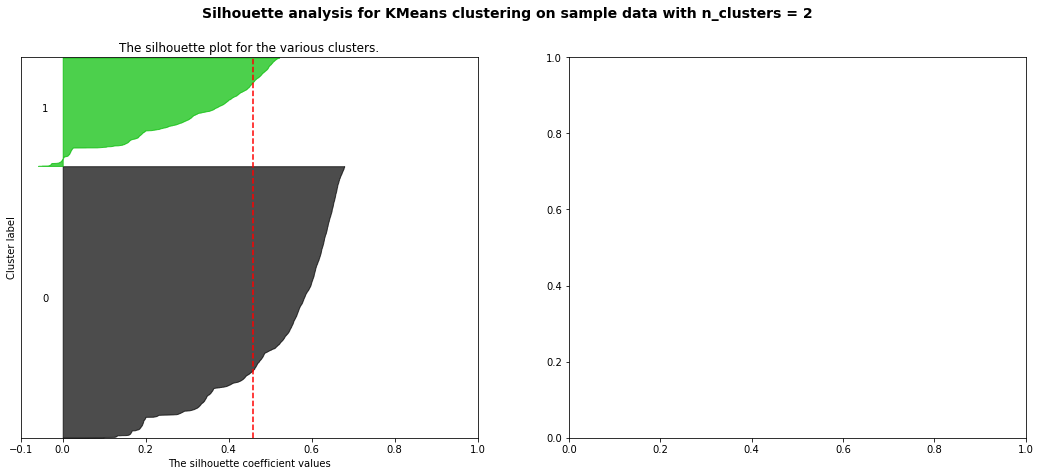

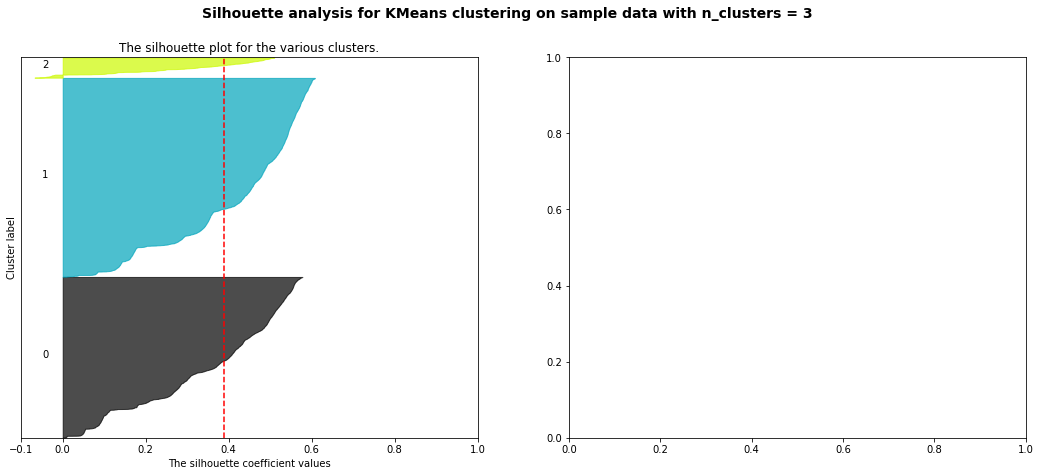

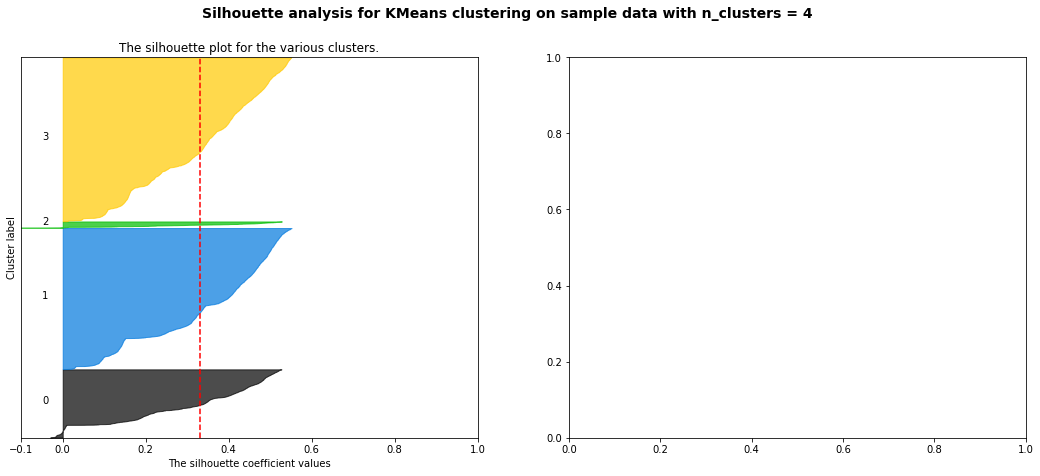

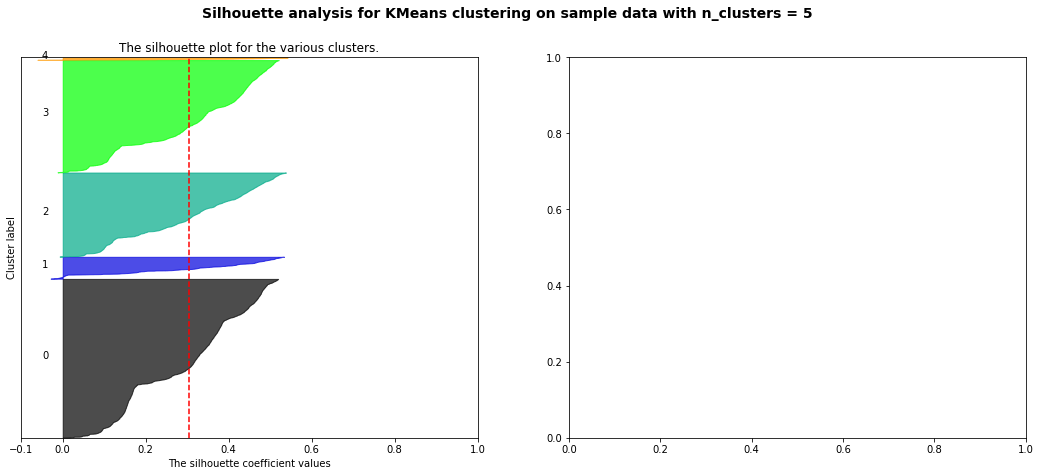

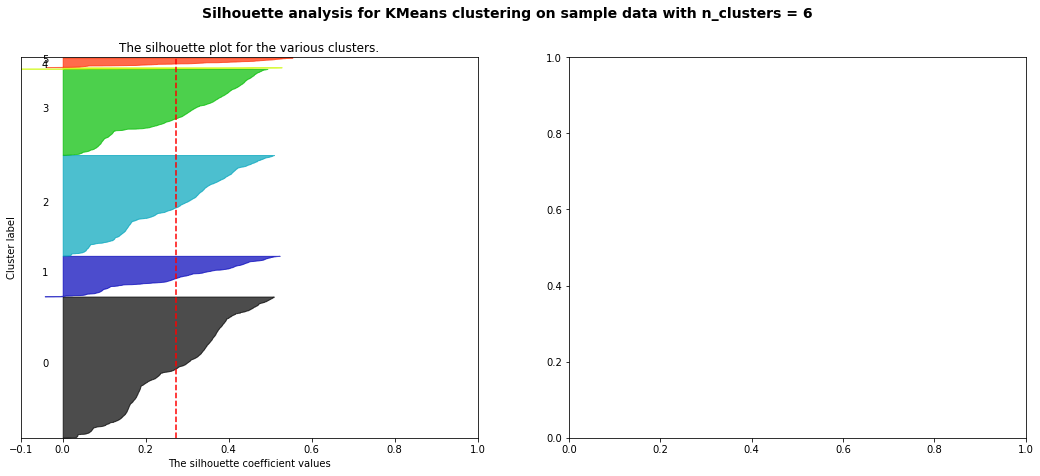

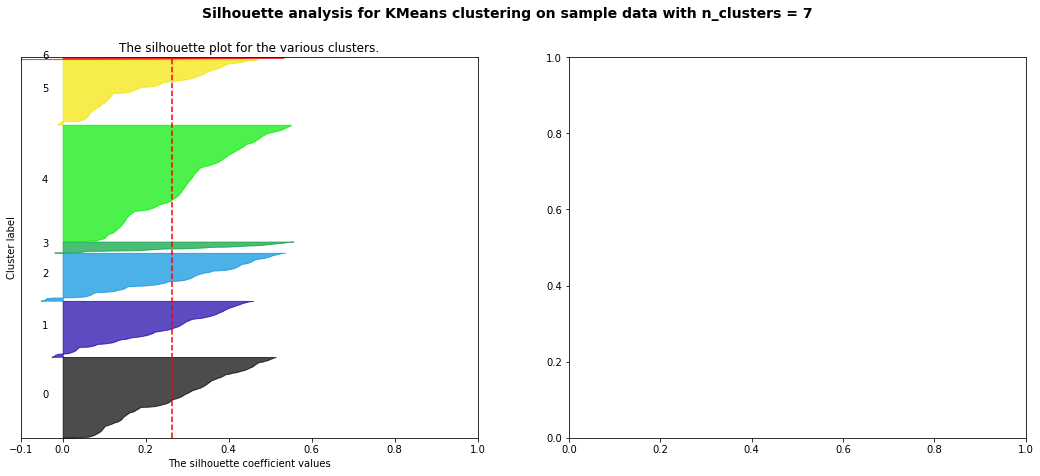

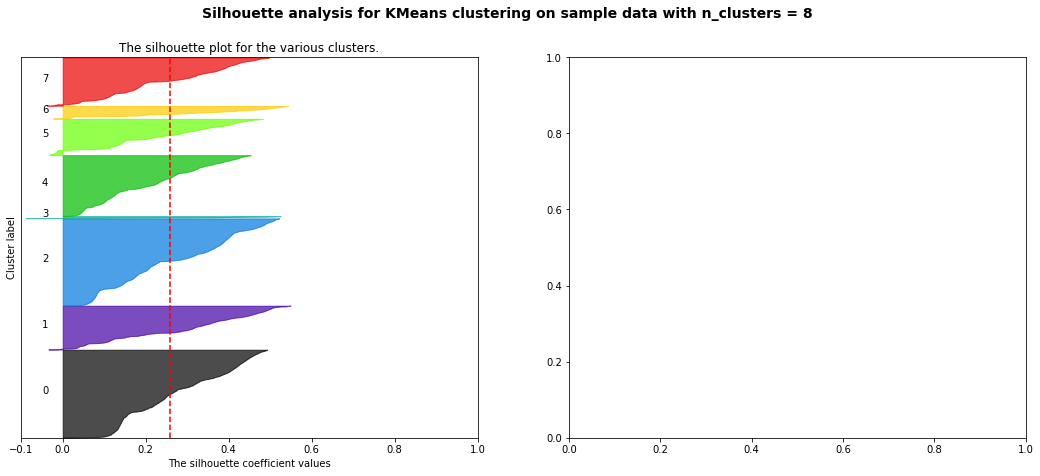

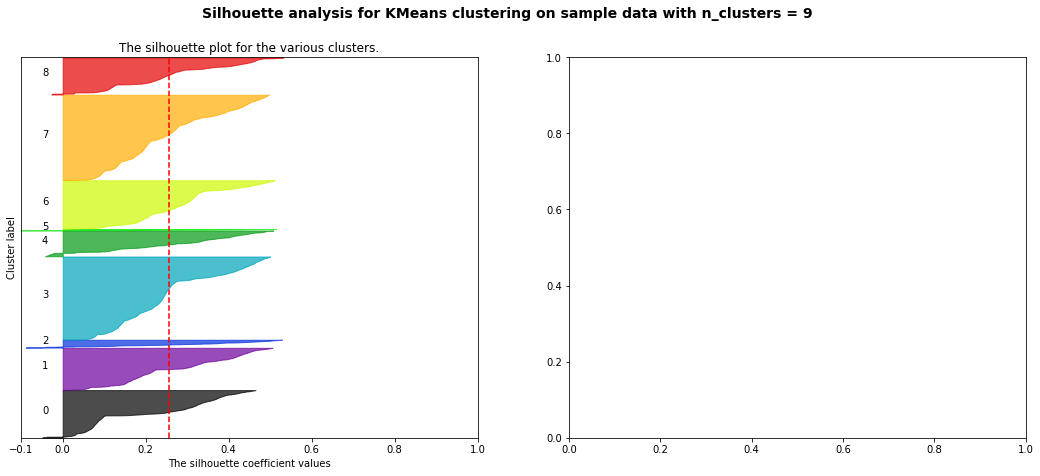

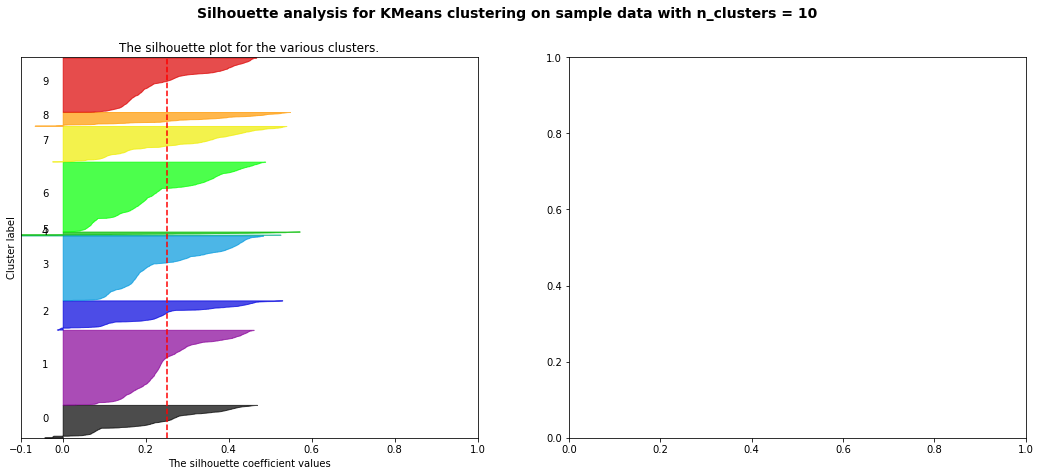

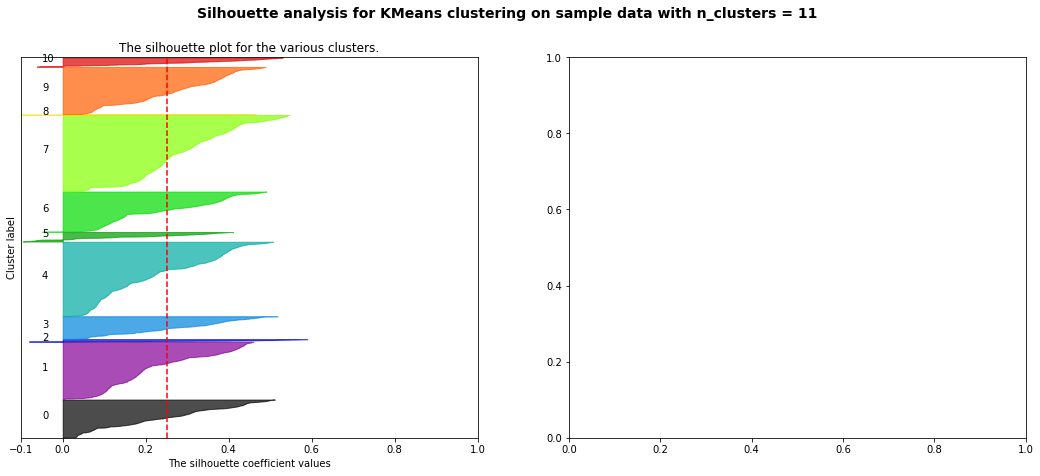

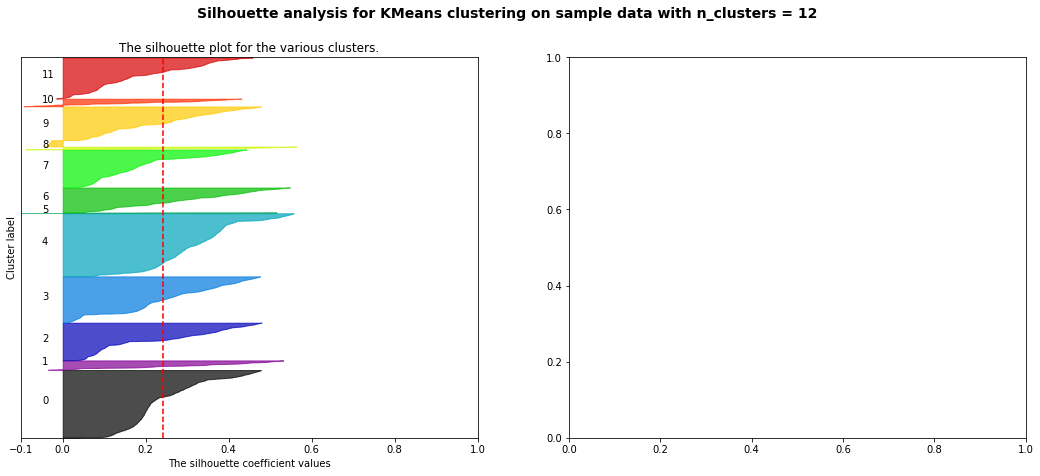

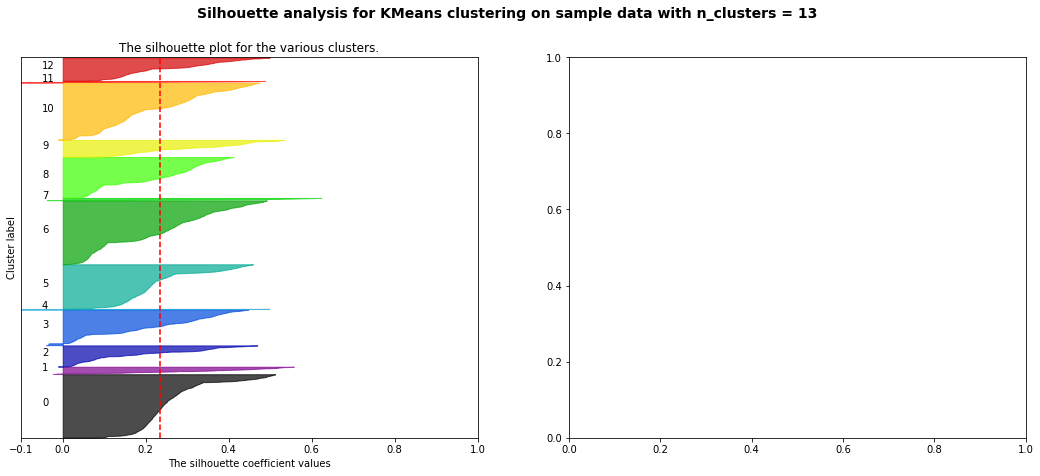

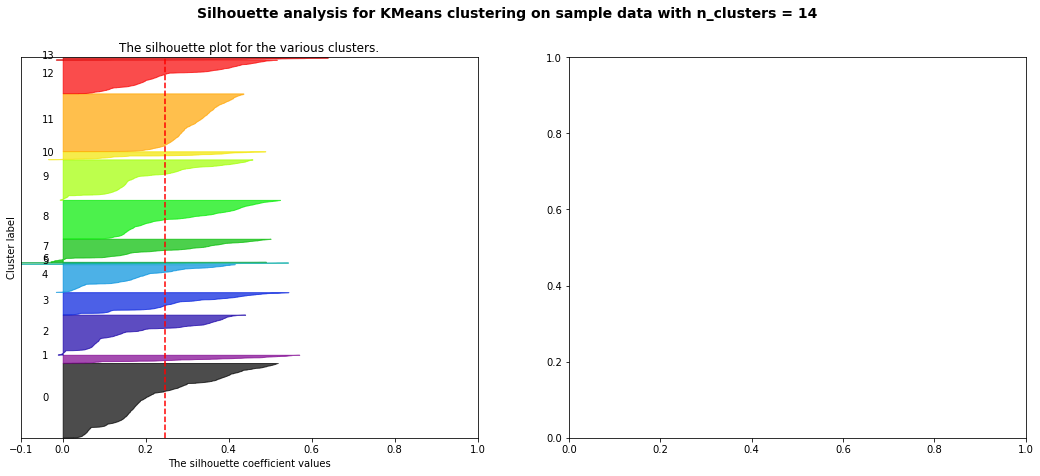

In [480]:
X_knnable = preprocess.fit_transform(X)

range_n_clusters = range(2, 15)

plt.ion()

for n_clusters in tqdm_notebook(range_n_clusters):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_knnable) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_knnable)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_knnable, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_knnable, cluster_labels)

    y_lower = 10
    for i in tnrange(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
#     ax2.scatter(X_knnable[:, 0], X_knnable[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                 c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
#     ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
#                 c="white", alpha=1, s=200, edgecolor='k')

#     for i, c in enumerate(centers):
#         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
#                     s=50, edgecolor='k')

#     ax2.set_title("The visualization of the clustered data.")
#     ax2.set_xlabel("Feature space for the 1st feature")
#     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.ioff()

In [468]:
KMeans(n_clusters=10).fit_transform(X_knnable[temperature_columns_kept])

array([[ 0.01052842,  0.00516316,  0.0131092 , ...,  0.01397641,
         0.00721064,  0.00289622],
       [ 0.01433335,  0.00608172,  0.0171219 , ...,  0.00976894,
         0.00339915,  0.00350466],
       [ 0.01231438,  0.00504417,  0.01500804, ...,  0.01178128,
         0.00499417,  0.00158293],
       ..., 
       [ 0.01290545,  0.02055008,  0.01292381, ...,  0.03225804,
         0.02586662,  0.02189937],
       [ 0.01356117,  0.02139786,  0.01051141, ...,  0.03242847,
         0.02579413,  0.02100258],
       [ 0.01890328,  0.02930894,  0.01618328, ...,  0.04205209,
         0.03507984,  0.03018091]])